In [160]:
%matplotlib inline

# Steady State Conduction Through a Wall Assembly
Let's start with a steady state conduction problem. Based on Fourier's Law:
\begin{equation}
    q_x = -k\frac{dT}{dx}
\end{equation}
    k is the thermal conductivity, W/m-K


Assume we have a homogeneous material layer, with thermal conductivity k, thickness L and area A. The material layer is has a cold side and hot side, which causes conduction heat transfer, then we have:
\begin{equation}
    q = \frac{(T_{hot}-T_{cold})kA}{L}
\end{equation}
We can then substitute layer information with total thermal resistance, R:
\begin{equation}
    q = \frac{T_{hot}-T_{cold}}{R} \;with\; R = \frac{L}{kA}
\end{equation}
Then we can setup a sinosoid function to represent the hot surface temperature variation, and a constant value for cold surface temperature.

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


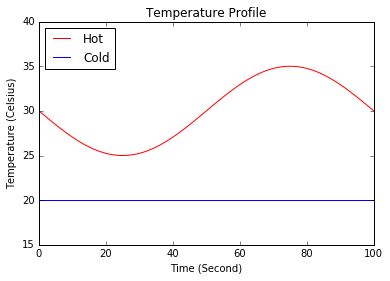

In [161]:
import numpy as np
import matplotlib.pyplot as plt
#First create a sinosoid wave with 100 elements
wave = np.sin(np.linspace(-np.pi,np.pi,100))
#Create average hot side temperature of 30C with 5 degrees sinosoid variation, 100 seconds per period
temp_hot = 30 + 5*wave
#Then create a constant cold side temperature of 20C
temp_cold = np.linspace(20.0,20.0,100)
#Plot those temperature curves
x = np.linspace(0,100,100)
fig, ax = plt.subplots()
ax.plot(x,temp_hot,"r",label="Hot")
ax.plot(x,temp_cold,"b",label="Cold")
ax.legend(loc=2) # upper left corner
ax.set_ylim(15,40)
ax.set_xlabel('Time (Second)')
ax.set_ylabel('Temperature (Celsius)')
ax.set_title('Temperature Profile')
fig.show()

Before we start up the actual calculation, let's take advantage of the object oriented programming and set up two classes that represent materials and layers. We can save a lot of time and effort by using object oriented programming!

In [162]:
#Set up the simple material class
class Material:
    def __init__(self, name, thermCond):
        self.name = name
        self.thermCond = thermCond

#Set up the layer class
class Layer:
    def __init__(self, name, material, thickness, area):
        self.name = name
        self.material = material
        self.thickness = thickness
        #Note that area here is unitless
        self.area = area
        #Calculates total thermal resistance of the layer using the update thermal resistance function
        self.UpdateThermRes()
    
    #Use function here so that it's reusable later
    def UpdateThermRes(self):
        self.thermRes = self.thickness/(self.material.thermCond*self.area)

After both classes are set up, let's create our testing material and layer. The testing material should have a total thermal resistance of 2 m^2-K/W

In [163]:
#Testing material with thermal conductivity of 0.5W/m-K
test_mat = Material("test",0.5)
#Testing layer with 1m thickness, 1 unit area
test_layer = Layer("test",test_mat,1.0,1.0)
#Print and inspect total thermal resistance
print('Total thermal resistance is %5.3f W/K-m2' %test_layer.thermRes)

Total thermal resistance is 2.000 W/K-m2


After we have successfully set up the testing layer, we need to create a steady state conduction heat transfer function so that it can be reused later.

In [164]:
#Create Steady State Conduction Heat Transfer, SI unit
#This method takes input temperature 1, temperature 2 and total thermal resistance R
#Note that we need to know the calculation time step, in this case it's 1 sec
def Cond_SS(temp1,temp2,thermRes,timestep):
    return (temp1-temp2)/thermRes * timestep

After everything is ready, we can start calculate the heat flux from the hot surface to the cold surface.

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


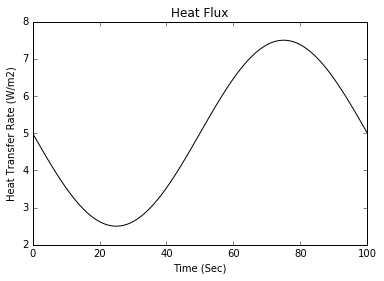

In [165]:
#Calculate the temperature, good thing about numpy is that we don't have to loop every single value,
#and the array manipulation is very fast.
q = Cond_SS(temp_hot,temp_cold,test_layer.thermRes,1) #Time step is 1 sec
#Let's plot the result
fig, ax = plt.subplots()
ax.plot(x,q,"k")
ax.set_xlabel('Time (Sec)')
ax.set_ylabel('Heat Transfer Rate (W/m2)')
ax.set_title('Heat Flux')
fig.show()

The function works as expected. However wall constructions usually contains several layers of meterial, in parallel and in series. Luckily we can represent this similar to electrical circuits. Let's set up a class which represents wall construction, and make layers in series into a construction list, and layers in parallel a nested list.

In [166]:
#Set up wall class
class Wall:
    def __init__(self,name,layers):
        self.name = name
        #Note that layer is from outisde to inside
        self.layers = layers
        self.UpdateThermRes()
    
    def UpdateThermRes(self):
        self.thermRes = 0
        for layer in self.layers:
            #check if this layer is a parallel of several layers:
            if isinstance(layer,list):
                #Calculate layer thermal resistance use parallel law
                #The area of layer is the fraction of total wall area
                #This is the reason why we have chose to use the unitless area earlier
                self.thermRes += 1/sum(l.area/l.thermRes for l in layer)
            else:
                self.thermRes += layer.thermRes
                
#We will add more functions later to enable editing layers to be more dynamic and flexible

After the wall class is constructed, let's create a wall construction with four layers with different materials, three in series and one in parallel to represent the thermal bridging:
Layer 1: material 1, in parallel with layer 2, with area fraction 0.8
Layer 2: material 2, in parallel with layer 1, with area fraction 0.2
Layer 3: material 3, in series with layer 1 and 2
Layer 4: material 4, in series with layer 1 and 2, 3

In [167]:
#Create First and Second Layer, they have same thickness since they are in parallel
material1 = Material("1", 0.5)
material2 = Material("2", 1.5)
layer1 = Layer("1", material1, 1, 0.8)
layer2 = Layer("2", material2, 1, 0.2)

#Next create other two layers and create a wall construction class
material3 = Material("3", 0.2)
layer3 = Layer("3", material3, 1.5, 1)
material4 = Material("4", 1.2)
layer4 = Layer("4", material4, 0.2, 1)
wall = Wall("sample wall with thermal bridging",[[layer1,layer2],layer3,layer4])

#Inspect the total thermal resistance
print("Total Thermal Resistance of the Wall Assembly is: %5.3f W/K-m2" %wall.thermRes)

Total Thermal Resistance of the Wall Assembly is: 10.298 W/K-m2


Now this Wall assembly has finished and we have obtained the total thermal resistance, let's use the steady state conduction function to solve the heat balance:

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


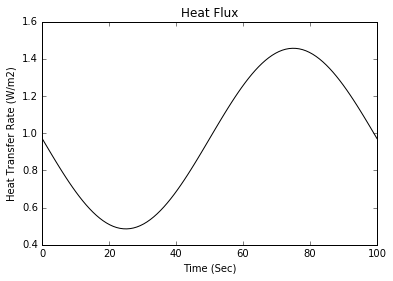

In [168]:
q_wall = Cond_SS(temp_hot,temp_cold,wall.thermRes,1) #Time step is 1 sec
#Let's plot the result
fig, ax = plt.subplots()
ax.plot(x,q_wall,"k")
ax.set_xlabel('Time (Sec)')
ax.set_ylabel('Heat Transfer Rate (W/m2)')
ax.set_title('Heat Flux')
fig.show()

#Transient Conduction
We have finished the steady state section. However this is not realistic for materials with high thermal mass, such as typical wall constructions. Thermal mass or thermal storage will bring delayed effect of the heat transfer process and we will try to model it in this section.
##Lumped Parameter
The first is to consider the wall as a whole and calculate the thermal mass as a whole layer. But before that we need to update our classes so that they include information about the thermal mass. The unit of thermal mass is J/kg, and we need density property kg/m3 as well.

##Conduction Transfer Function
##Comparison Test

In [169]:
#New Material Class with density and thermal capacity
class Material:
    def __init__(self, name, density, thermCond, thermCap):
        self.name = name
        self.density = density
        self.thermCond = thermCond
        self.thermCap = thermCap

#Set up the layer class
class Layer:
    def __init__(self, name, material, thickness, area):
        self.name = name
        self.material = material
        self.thickness = thickness
        #Note that area here is unitless
        self.area = area
        #Calculates total thermal resistance of the layer using the update thermal resistance function
        self.UpdateThermRes()
        #Update new properties, remember to calculate density first
        self.UpdateThermCap()
    
    #Use function here so that it's reusable later
    def UpdateThermRes(self):
        self.thermRes = self.thickness/(self.material.thermCond*self.area)
    
    #Update Density per unit area in kg/m2
    def UpdateDensity(self):
        self.density = self.material.density * self.thickness
        
    #Update Heat Capacity per unit area in J/m2
    def UpdateThermCap(self):
        #Update density first
        self.UpdateDensity()
        self.thermCap = self.density * self.material.thermCap

Now create new wall class that calculates total thermal capacity

In [189]:
#Set up wall class
class Wall:
    def __init__(self,name,layers):
        self.name = name
        #Note that layer is from outisde to inside
        self.layers = layers
        self.UpdateThermRes()
        self.UpdateThermCap()
    
    def UpdateThermRes(self):
        self.thermRes = 0
        for layer in self.layers:
            #check if this layer is a parallel of several layers:
            if isinstance(layer,list):
                #Calculate layer thermal resistance use parallel law
                #The area of layer is the fraction of total wall area
                #This is the reason why we have chose to use the unitless area earlier
                self.thermRes += 1/sum(l.area/l.thermRes for l in layer)
            else:
                self.thermRes += layer.thermRes
    
    #Calculate thermal capacitance is relative simple, just adding each layer together
    def UpdateThermCap(self):
        self.thermCap = 0
        for layer in self.layers:
            if isinstance(layer,list):
                self.thermCap += sum(l.thermCap for l in layer)
            else:
                self.thermCap += layer.thermCap

Then we recreate the materials and layers

In [190]:
#Create First and Second Layer, they have same thickness since they are in parallel
material1 = Material("1", 400, 0.5, 800)
material2 = Material("2", 2000, 1.5, 1500)
layer1 = Layer("1", material1, 0.015, 0.8)
layer2 = Layer("2", material2, 0.015, 0.2)

#Next create other two layers and create a wall construction class
material3 = Material("3", 600, 0.2, 800)
layer3 = Layer("3", material3, 0.008, 1)
material4 = Material("4", 1600, 1.2, 1600)
layer4 = Layer("4", material4, 0.002, 1)
wall = Wall("sample wall with thermal bridging",[[layer1,layer2],layer3,layer4])

#Inspect new properties
print("Total Thermal Resistance of the Wall Assembly is: %5.3f W/K-m2" %wall.thermRes)
print("Total Thermal Capacitance of the Wall Assembly is: %5.3f J/m2" %wall.thermCap)

Total Thermal Resistance of the Wall Assembly is: 0.081 W/K-m2
Total Thermal Capacitance of the Wall Assembly is: 58760.000 J/m2


We still use the old temperature profile, however let's use a time step 10 times larger to emulate the thermal mass, since now the heat flow will be more slow response. The equatiion for transient conduction is:

In [191]:
#Update temperature isntead of direct heat flow, heat flow can be solved by SS
def Cond_LP(temp1,temp2,thermRes,thermCap,timestep):
    new_temp2 = (temp1-temp2)/thermRes/thermCap*timestep + temp2
    return new_temp2

Keep the original hot side temperature, but with free floating cold side temperature until it reaches hot side temperature

In [192]:
import numpy as np
import matplotlib.pyplot as plt
#First create a sinosoid wave with 100 elements
wave = np.sin(np.linspace(-np.pi,np.pi,100))
#Create average hot side temperature of 30C with 5 degrees sinosoid variation, 100 seconds per period
temp_hot = 30 + 5*wave
#Precreate cold side temperature of 20C, then update it
temp_cold = np.linspace(20.0,20.0,100) 

#Calculate transient conduction, free floating starting from 20C
for i in range(0,99):
    temp_cold[i+1] = Cond_LP(temp_hot[i],temp_cold[i],wall.thermRes,wall.thermCap,100)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


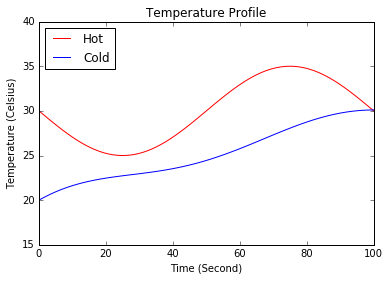

In [193]:
#Plot those temperature curves
x = np.linspace(0,100,100)
fig, ax = plt.subplots()
ax.plot(x,temp_hot,"r",label="Hot")
ax.plot(x,temp_cold,"b",label="Cold")
ax.legend(loc=2) # upper left corner
ax.set_ylim(15,40)
ax.set_xlabel('Time (Second)')
ax.set_ylabel('Temperature (Celsius)')
ax.set_title('Temperature Profile')
fig.show()

##Thermal Network (Finite Element)

We then use the thermal network methods used in EnergyPlus and ESP-r finite difference method.
The core of this method is Crank-Nicolson method and layer discretization.
I'll add more details in the future, but let's start with the coding process.

In [195]:
#Create First and Second Layer, they have same thickness since they are in parallel
material1 = Material("1", 400, 0.5, 800)
material2 = Material("2", 2000, 1.5, 1500)
layer1 = Layer("1", material1, 0.015, 0.8)
layer2 = Layer("2", material2, 0.015, 0.2)

wall = Wall("sample wall without thermal bridging",[layer1,layer2])

In [196]:
#Number of nodes within each layer
n = 3



#Loop that generates Crank-Nicolson Formulation Right Hand Side (explicit and implicit)
#The input is the wall class
def CrankNicolson(wall,n,timestep):
    #Number of nodes based on number of series layers and nodes within each layer
    #Exterior node starts with 0
    n_nodes = len(wall.layers) * (n-1)
    #nested list ready for numpy conversion
    rows_exp = []
    rows_imp = []
    #Check and recreate wall layers, making sure parallel layers are corrected
    cnLayers = []
    cnMaterials = []
    for layer in wall.layers:
        if isinstance(layer,list):
            #find out parallel properties:
            density = sum(l.area * l.material.density for l in layer)
            thermCond = sum(l.area/l.thermRes for l in layer)
            thermCap = sum(l.area * l.material.thermCap for l in layer)
            #create an equivelent material
            cnMaterials.append(Material("Equivelent",density,thermCon,thermCap))
            #use an arbitary layer in list, since thickness are the same
            cnLayers.append(layer[0])
        else:
            cnMaterials.append(layer.material)
            cnLayers.append(layer)
    for i in range(0,n_nodes + 1):     
        # Set up exterior boundary conditions
        if i == 0:
            row_exp = [0] * (n_nodes+1)
            row_imp = [0] * (n_nodes+1)
            layer = cnLayers[i//n]
            material = cnMaterials[i//n]
            row_exp[i+1] = material.thermCond/(layer.thickness/(n-1))**2
            row_exp[i] = material.density*material.thermCap/timestep-row_exp[i+1]
            row_imp[i+1] = -row_exp[i+1]
            row_imp[i] = material.density*material.thermCap/timestep+row_exp[i+1]
        # Set up interior boundary conditions
        elif i == n_nodes:
            row_exp = [0] * (n_nodes+1)
            row_imp = [0] * (n_nodes+1)
            layer = cnLayers[i//n]
            material = cnMaterials[i//n]
            row_exp[i-1] = material.thermCond/(layer.thickness/(n-1))**2
            row_exp[i] = material.density*material.thermCap/timestep-row_exp[i-1]
            row_imp[i-1] = -row_exp[i-1]
            row_imp[i] = material.density*material.thermCap/timestep+row_exp[i-1]
        # Set up interfacases
        elif i%(n-1) == 0:
            row_exp = [0] * (n_nodes+1)
            row_imp = [0] * (n_nodes+1)
            layer_prev = cnLayers[(i-1)//n]
            material_prev = cnMaterials[(i-1)//n]
            layer_next = cnLayers[(i+1)//n]
            material_next = cnMaterials[(i+1)//n]
            delta_x = (layer_prev.thickness/(n-1)/2+layer_next.thickness/(n-1)/2)
            #Calculating Explicit Form
            row_exp[i-1] = material_prev.thermCond/(delta_x*(layer_prev.thickness/(n-1)))
            row_exp[i+1] = material_next.thermCond/(delta_x*(layer_next.thickness/(n-1)))
            row_exp[i] = 2*(material_prev.density*material_prev.thermCap*layer_prev.thickness/((n-1)*2)/delta_x + \
                     material_next.density*material_next.thermCap*layer_next.thickness/((n-1)*2)/delta_x)/timestep -\
                    row_exp[i-1] - row_exp[i+1]
            #Calculating Implicit Form
            row_imp[i-1] = -row_exp[i-1]
            row_imp[i+1] = -row_exp[i+1]
            row_imp[i] = 2*(material_prev.density*material_prev.thermCap*layer_prev.thickness/((n-1)*2)/delta_x + \
                     material_next.density*material_next.thermCap*layer_next.thickness/((n-1)*2)/delta_x)/timestep +\
                    row_exp[i-1] + row_exp[i+1]
        # Homogeneous nodes
        else:
            row_exp = [0] * (n_nodes+1)
            row_imp = [0] * (n_nodes+1)
            layer = cnLayers[i//n]
            material = cnMaterials[i//n]
            #if there are parallel layers
            row_exp[i-1] = material.thermCond/(layer.thickness/(n-1))**2
            row_exp[i+1] = row_exp[i-1]
            row_exp[i] = 2*material.density*material.thermCap/timestep-row_exp[i-1]-row_exp[i+1]
            #Calculating Implicit Form
            row_imp[i-1] = -row_exp[i-1]
            row_imp[i+1] = -row_exp[i+1]
            row_imp[i] = 2*material.density*material.thermCap/timestep+row_exp[i-1]+row_exp[i+1]
        rows_exp.append(row_exp)
        rows_imp.append(row_imp)
    return np.array(rows_exp), np.array(rows_imp)

In [197]:
timestep = 600
cn_exp, cn_imp =  CrankNicolson(wall,3,100.0)
#print cn_imp
print(cn_exp)
print(cn_imp)

[[ -5688.88888889   8888.88888889      0.              0.              0.        ]
 [  8888.88888889 -11377.77777778   8888.88888889      0.              0.        ]
 [     0.           8888.88888889  -2355.55555556  26666.66666667      0.        ]
 [     0.              0.          26666.66666667   6666.66666667
   26666.66666667]
 [     0.              0.              0.          26666.66666667
    3333.33333333]]
[[  12088.88888889   -8888.88888889       0.               0.               0.        ]
 [  -8888.88888889   24177.77777778   -8888.88888889       0.               0.        ]
 [      0.           -8888.88888889   68755.55555556  -26666.66666667
        0.        ]
 [      0.               0.          -26666.66666667  113333.33333333
   -26666.66666667]
 [      0.               0.               0.          -26666.66666667
    56666.66666667]]


We can then solve this problem using the energy balance method. Note that the actual temperature has to be guessed each time step. So we set up the residual function first.

In [198]:
print(np.linalg.det(cn_imp))

6.96958245575e+22


After the residual function is set up, we need to use some optimizatino method inside scipy to minimize the residual and output the temperature, the input to the function will be explicit C-N, implicit C-N and temperature of last time step.

In [199]:
length = 86400
n = int(length//timestep)
wave = np.sin(np.linspace(-np.pi,np.pi,n))
#Create average hot side temperature of 30C with 5 degrees sinosoid variation, 100 seconds per period
temp_hot = 30 + 5*wave
#temp_hot = np.linspace(30,30,10000)
temp_cold = np.linspace(20.0,20.0,n) 


temp_start = np.array([30,20,20,20,20])[np.newaxis].T

In [206]:
temp_update = temp_start

#Timing of calculation
import time
start_time = time.time()
for i in range(0,n-1):    
    temp_update = scipy.linalg.solve(cn_imp,cn_exp.dot(temp_update))
    temp_cold[i+1] = temp_update[3]
    temp_update[0] = temp_hot[i+1]
    temp_update[4] = temp_update[3]

elapsed_time = (time.time()-start_time)*1000
print(len(temp_cold),len(temp_hot))
print("Total Calculation time is: %5.3f ms" %elapsed_time)

144 144
Total Calculation time is: 15.196 ms


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


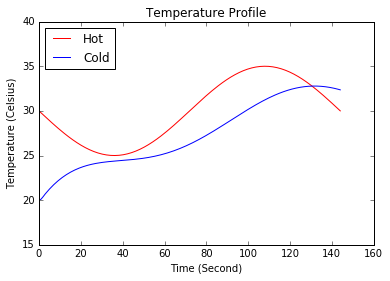

In [201]:
#Plot those temperature curves
x = np.linspace(0,n,n)
fig, ax = plt.subplots()
ax.plot(x,temp_hot,"r",label="Hot")
ax.plot(x,temp_cold,"b",label="Cold")
ax.legend(loc=2) # upper left corner
ax.set_ylim(15,40)
ax.set_xlabel('Time (Second)')
ax.set_ylabel('Temperature (Celsius)')
ax.set_title('Temperature Profile')
fig.show()

## Forward Euler method of solving conduction problem
This is the fully explicit way of solving the problem.

\begin{equation}
\frac{(\Delta c_p \Delta x \Delta y)}{\Delta t}(T_l^{t+\Delta t}-T_l^t)
\end{equation}

Different from Crank Nicolson, we only need to calculate an additional left hand side.
However, for forward Euler to ensure stability the timestep has to be $\Delta t \le \Delta x^2 / (2 D)$.

In [207]:
def Explicit(wall,n,timestep):
    #Number of nodes based on number of series layers and nodes within each layer
    #Exterior node starts with 0
    n_nodes = len(wall.layers) * (n-1)
    #nested list ready for numpy conversion
    rows = []
    #Check and recreate wall layers, making sure parallel layers are corrected
    cnLayers = []
    cnMaterials = []
    for layer in wall.layers:
        if isinstance(layer,list):
            #find out parallel properties:
            density = sum(l.area * l.material.density for l in layer)
            thermCond = sum(l.area/l.thermRes for l in layer)
            thermCap = sum(l.area * l.material.thermCap for l in layer)
            #create an equivelent material
            cnMaterials.append(Material("Equivelent",density,thermCon,thermCap))
            #use an arbitary layer in list, since thickness are the same
            cnLayers.append(layer[0])
        else:
            cnMaterials.append(layer.material)
            cnLayers.append(layer)
    for i in range(0,n_nodes + 1):
        if i == 0:
            row= [0] * (n_nodes+1)
            layer = cnLayers[i//n]
            material = cnMaterials[i//n]
            row[i+1] = material.thermCond/(layer.thickness/(n-1))**2
            row[i] = material.density*material.thermCap/timestep-row[i+1]
        elif i == n_nodes:
            row= [0] * (n_nodes+1)
            layer = cnLayers[i//n]
            material = cnMaterials[i//n]
            row[i-1] = material.thermCond/(layer.thickness/(n-1))**2
            row[i] = material.density*material.thermCap/timestep-row[i-1]
        # Set up interfacases
        elif i%(n-1) == 0:
            row = [0] * (n_nodes+1)
            layer_prev = cnLayers[(i-1)//n]
            material_prev = cnMaterials[(i-1)//n]
            layer_next = cnLayers[(i+1)//n]
            material_next = cnMaterials[(i+1)//n]
            delta_x_prev = layer_prev.thickness/(n-1)
            delta_x_next = layer_next.thickness/(n-1)
            delta_x = delta_x_prev + delta_x_next
            avg_cap = material_prev.density*material_prev.thermCap*delta_x_prev/delta_x/2 + \
                    material_next.density*material_next.thermCap*delta_x_next/delta_x/2
            row[i-1] = material_prev.thermCond*timestep/(delta_x_prev*avg_cap)
            row[i+1] = material_next.thermCond*timestep/(delta_x_next*avg_cap)
            row[i] = -(row[i-1] + row[i+1])
        else:
            row= [0] * (n_nodes+1)
            layer = cnLayers[i//n]
            material = cnMaterials[i//n]
            delta_x = layer.thickness/(n-1)
            row[i-1] = material.thermCond*timestep/(delta_x*delta_x/2*material.thermCap*material.density)
            row[i+1] = row[i-1]
            row[i] = -2*row[i-1]
        rows.append(row)
    return np.array(rows)

In [208]:
#timestep in forward Euler has to be very small

timestep = 15
exp_left = Explicit(wall,3,timestep)
print(exp_left)

[[  1.24444444e+04   8.88888889e+03   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  8.33333333e-01  -1.66666667e+00   8.33333333e-01   0.00000000e+00
    0.00000000e+00]
 [  0.00000000e+00   1.20481928e-03  -4.81927711e-03   3.61445783e-03
    0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   2.66666667e-01  -5.33333333e-01
    2.66666667e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   2.66666667e+04
    1.73333333e+05]]


In [209]:
length = 86400
n = int(length//timestep)
wave = np.sin(np.linspace(-np.pi,np.pi,n))
#Create average hot side temperature of 30C with 5 degrees sinosoid variation, 100 seconds per period
temp_hot = 30 + 5*wave

temp_cold = np.linspace(20.0,20.0,n) 

temp_start = np.array([30,20,20,20,20])[np.newaxis].T
print(temp_start)

[[30]
 [20]
 [20]
 [20]
 [20]]


In [210]:
temp_start + np.dot(exp_left, temp_start)

array([[  5.51141111e+05],
       [  2.83333333e+01],
       [  2.00000000e+01],
       [  2.00000000e+01],
       [  4.00002000e+06]])

In [211]:
temp_update = temp_start

time_start = time.time()
for i in range(0,n-1):    
    temp_update = temp_update + np.dot(exp_left,temp_update)
    temp_cold[i+1] = temp_update[3]
    temp_update[0] = temp_hot[i+1]
    temp_update[4] = temp_update[3]

elapsed_time = (time.time()-time_start)*1000
print("Total Calculation time is: %5.3f ms" %elapsed_time)

Total Calculation time is: 32.242 ms


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


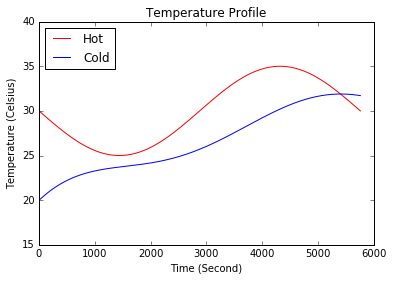

In [212]:
#Plot those temperature curves
x = np.linspace(0,n,n)
fig, ax = plt.subplots()
ax.plot(x,temp_hot,"r",label="Hot")
ax.plot(x,temp_cold,"b",label="Cold")
ax.legend(loc=2) # upper left corner
ax.set_ylim(15,40)
ax.set_xlabel('Time (Second)')
ax.set_ylabel('Temperature (Celsius)')
ax.set_title('Temperature Profile')
fig.show()